# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import LinearRegression, Lasso

from scipy.stats import randint, uniform

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [201]:
# YOUR CODE HERE
path = '/Users/Yohann/Downloads/tv_movies_popularity.csv'

df = pd.read_csv(path)
data = df.copy()

In [202]:
print(df.shape)
print(df.drop_duplicates().shape)
data.drop_duplicates(inplace=True)

(6864, 17)
(6464, 17)


We found and removed 400 duplicate rows

In [203]:
data.isnull().sum()

original_title                  0
title                           1
popularity                      0
release_date                    0
duration_min                    0
description                     0
budget                          0
revenue                      3847
original_language               0
status                          0
number_of_awards_won            0
number_of_nominations           0
has_collection                  0
all_genres                      0
top_countries                   0
number_of_top_productions       0
available_in_english            0
dtype: int64

Revenue seems to have many missing values, let's drop it

In [204]:
data = data.drop(columns='revenue')

In [205]:
data.head()

,original_title,title,popularity,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,en,Released,97,145,0,Drama,United States of America,0,True
3,Kahaani,Kahaani,3.174936,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,The Possession,The Possession,7.286477,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True


### 🧪 Run the following cell to save your results

In [206]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

<AxesSubplot:>

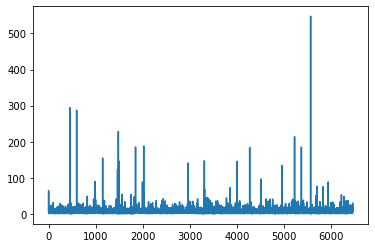

In [207]:
data.popularity.plot()

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

In [208]:
# YOUR CODE HERE
scoring = 'neg_mean_squared_log_error'

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [209]:
# YOUR CODE HERE
X = data.drop(columns='popularity')
y = data.popularity

In [210]:
print(X.shape, y.shape)

(6464, 15) (6464,)


### Basic pipeline

📝 **Check unique values per features**

In [308]:
for col in X.columns.tolist():
    print(col, X[col].nunique())

original_title 6351
title 6337
release_date 4321
duration_min 152
description 6450
budget 636
original_language 42
status 3
number_of_awards_won 124
number_of_nominations 180
has_collection 2
all_genres 745
top_countries 320
number_of_top_productions 5
available_in_english 2


Let's explore each column a bit further

In [212]:
#some similar original titles appear a few times
X[cols[0]].value_counts()

Hercules          3
King Kong         3
Anna Karenina     3
RoboCop           2
Frozen            2
                 ..
Monster Trucks    1
December Boys     1
Jab We Met        1
Zulu              1
Monsters          1
Name: original_title, Length: 6351, dtype: int64

In [213]:
#Same for titles
X[cols[1]].value_counts()

Hercules                3
Beauty and the Beast    3
King Kong               3
Anna Karenina           3
Frozen                  2
                       ..
Imperium                1
Philadelphia            1
Rain Man                1
Battle for Terra        1
Monsters                1
Name: title, Length: 6337, dtype: int64

In [214]:
#many movies were released on the same day .. makes sense
X[cols[2]].value_counts()

2009-01-16    7
2008-12-25    7
2011-09-09    7
2014-12-25    7
2012-09-14    6
             ..
1983-07-15    1
1996-05-17    1
1968-03-22    1
2016-12-06    1
2008-05-14    1
Name: release_date, Length: 4321, dtype: int64

In [215]:
#Same length for many movies - nothing crazy here
X[cols[3]].value_counts()

100.0    207
97.0     183
95.0     175
96.0     173
105.0    172
        ... 
200.0      1
190.0      1
194.0      1
59.0       1
224.0      1
Name: duration_min, Length: 152, dtype: int64

In [216]:
#Some movie writers were not extremly creative :-)
X[cols[4]].value_counts()

The story of                                                                                                                                                        9
The life of                                                                                                                                                         3
The relationship between                                                                                                                                            2
The true story of                                                                                                                                                   2
Based on the true story of                                                                                                                                          2
                                                                                                                                                                   ..
When

In [217]:
#That's interesting! We have a lot of movies with no-budget (or no info on budget)
X[cols[5]].value_counts()

0           1424
20000000     184
25000000     171
15000000     169
30000000     154
            ... 
4180000        1
2380000        1
8376800        1
99000000       1
22700000       1
Name: budget, Length: 636, dtype: int64

In [218]:
#Most movies are in English, then French.Interesting languages are also present.
X[cols[6]].value_counts()

en    5658
fr     165
hi     114
ja      81
es      63
it      45
ru      39
zh      38
de      37
ko      36
cn      33
ta      26
da      17
sv      14
te       9
pt       9
ml       8
tr       8
ro       7
nl       7
th       5
fa       5
pl       5
no       4
hu       4
bn       3
el       3
he       3
id       2
fi       2
cs       2
sr       2
af       1
ur       1
xx       1
is       1
ka       1
ar       1
bm       1
ca       1
nb       1
kn       1
Name: original_language, dtype: int64

In [61]:
#Only one in the rumored stage! Let's show it
X[cols[7]].value_counts()

Released           6459
Post Production       4
Rumored               1
Name: status, dtype: int64

In [63]:
#Rumor has been around for quite some time ..
X[X.status == 'Rumored']

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
1064,Extremities,Extremities,1986-08-22,89.0,A woman takes revenge on the man who invades h...,0,en,Rumored,1,1,0,"Drama, Thriller",United States of America,0,True


In [64]:
#Again we've got both extremes, 243 awards sound sick
X[cols[8]].value_counts()

0      2053
1      1068
2       626
3       447
4       313
       ... 
86        1
90        1
94        1
110       1
243       1
Name: number_of_awards_won, Length: 124, dtype: int64

In [65]:
#Obviously
X[X.number_of_awards_won == 243]

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
3328,12 Years a Slave,12 Years a Slave,2013-10-18,134.0,"In the antebellum United States,",20000000,en,Released,243,336,0,"Drama, History","United Kingdom, United States of America",1,True


In [66]:
#A bit more distributed
X[cols[9]].value_counts()

0      973
1      755
2      582
3      497
4      394
      ... 
98       1
78       1
160      1
168      1
291      1
Name: number_of_nominations, Length: 180, dtype: int64

In [68]:
X[cols[10]].value_counts()

0    5073
1    1391
Name: has_collection, dtype: int64

In [69]:
#Mostly dramas and comedies. Interestingly we have some mixed genres that we will have to take care of in the future
X[cols[11]].value_counts()

Drama                                     529
Comedy                                    403
Drama, Romance                            277
Comedy, Drama                             262
Comedy, Drama, Romance                    259
                                         ... 
Foreign, Horror, Mystery                    1
Action, Drama, Horror, Science Fiction      1
Action, Adventure, Drama, Horror            1
Adventure, Fantasy, Horror                  1
Comedy, Mystery, Science Fiction            1
Name: all_genres, Length: 745, dtype: int64

In [70]:
#USA comes first; again a mix of strings ..
X[cols[12]].value_counts()

United States of America                                                    3966
United Kingdom, United States of America                                     277
United Kingdom                                                               186
India                                                                        162
Germany, United States of America                                            133
                                                                            ... 
Australia, Hong Kong                                                           1
Czech Republic, Germany, Italy, United Kingdom, United States of America       1
Belgium, Spain, United Kingdom                                                 1
Czech Republic, France, United States of America                               1
Belgium, Denmark, South Africa, Sweden, United Kingdom                         1
Name: top_countries, Length: 320, dtype: int64

In [71]:
X[cols[13]].value_counts()

1    3050
0    2884
2     457
3      69
4       4
Name: number_of_top_productions, dtype: int64

In [73]:
#Most of them are availabel in EN
X[cols[14]].value_counts()

True     5807
False     657
Name: available_in_english, dtype: int64

In this baseline, let's forget about the columns below that are difficult to process

In [89]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [219]:
cols

['original_title',
 'title',
 'release_date',
 'duration_min',
 'description',
 'budget',
 'original_language',
 'status',
 'number_of_awards_won',
 'number_of_nominations',
 'has_collection',
 'all_genres',
 'top_countries',
 'number_of_top_productions',
 'available_in_english']

In [220]:
# YOUR CODE HERE
numerical = ['duration_min', 'budget', 'number_of_awards_won', \
              'number_of_nominations', 'has_collection', 'number_of_top_productions']
categorical = ['original_language', 'status', 'all_genres', 'has_collection',\
               'top_countries', 'available_in_english' ]

/Users/Yohann/miniforge3/envs/apple_tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Yohann/miniforge3/envs/apple_tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Yohann/miniforge3/envs/apple_tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

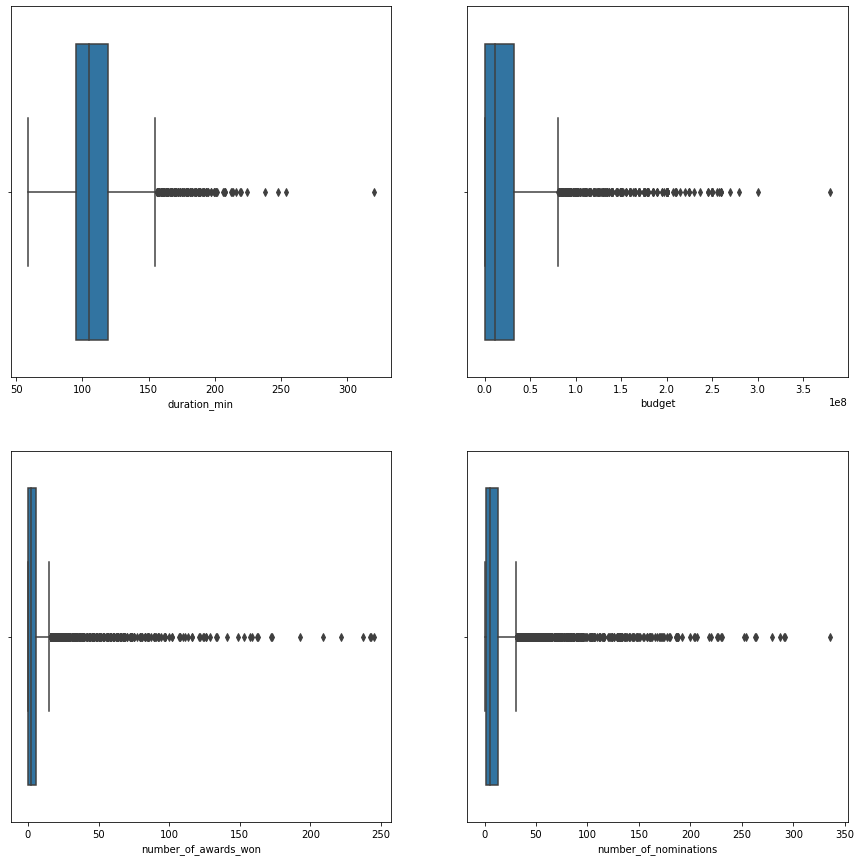

In [221]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for feature_name, ax in zip(numerical, axes.flatten()):
    sns.boxplot(X[feature_name], ax=ax)

We can see quite that all numerical features have many outliers -> we need to take that into account when scaling them

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [83]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')

In [20]:
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [108]:
categorical

['original_language',
 'status',
 'all_genres',
 'has_collection',
 'top_countries',
 'available_in_english']

In [424]:
basic_preprocessing = ColumnTransformer(
    transformers=[
        # Dropping columns that will not be used by the model
        ('drop_date_and_text', 'drop', ['description', 'original_title', 'title', 'release_date']),
        
        # Scaling continuous features with outliers
        ('robust_scaler', RobustScaler(), ['duration_min','budget',
             'number_of_awards_won',
             'number_of_nominations',
             'has_collection',
             'number_of_top_productions']),
        
        # One-hot encoding the categorical and boolean features 
        ('key_encoding', OneHotEncoder(handle_unknown = "ignore"), ['original_language',
             'status',
             'all_genres',
             'has_collection',
             'top_countries',
             'available_in_english']),
    ],
    sparse_threshold=0
)

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [426]:
basic_preprocessing.fit(X)
X_basic_preprocessing = basic_preprocessing.transform(X)
pd.DataFrame(X_basic_preprocessing)

,0,1,2,3,4,5,6,7,8,9,...,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119
0,-0.500000,0.093863,-0.333333,-0.250000,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.333333,0.907347,-0.166667,-0.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-0.240916,15.833333,11.666667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.708333,-0.306621,3.500000,1.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.541667,0.093863,-0.333333,0.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,0.541667,0.969922,-0.333333,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6460,-0.416667,0.250303,-0.333333,-0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6461,1.000000,0.156439,0.166667,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6462,-0.208333,-0.281590,3.833333,3.166667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [422]:
X_basic_preprocessing

<6464x1120 sparse matrix of type '<class 'numpy.float64'>'
	with 68254 stored elements in Compressed Sparse Row format>

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

In [139]:
X_basic_preprocessing.shape

(6464, 1120)

Wow, now we have 1120 features! That's a lot compared to our original 17 features .. let's try to make our model simpler to avoid complexity, curse of dimensionality and overfitting

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [140]:
# YOUR CODE HERE

l1_reg = Lasso()

basic_pipeline = make_pipeline(basic_preprocessing, l1_reg)

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [152]:
#cross val with pipeline and our scoring - returns test_score only
basic_scores = cross_validate(basic_pipeline, X, y, scoring=scoring)['test_score']

In [153]:
#Due to sklearn specificity we need to pass a minus before the scores
-basic_scores

array([0.30104374, 0.32162871, 0.31164205, 0.30222793, 0.33176182])

### 🧪 Save your results

Run the following cell to save your results

In [154]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [242]:
data.dtypes

original_title                object
title                         object
popularity                   float64
release_date                  object
duration_min                 float64
description                   object
budget                         int64
original_language             object
status                        object
number_of_awards_won           int64
number_of_nominations          int64
has_collection                 int64
all_genres                    object
top_countries                 object
number_of_top_productions      int64
available_in_english            bool
dtype: object

Release date is an object so we'll need to transform it to datetime

In [245]:
tmp = X.copy()

In [258]:
tmp[['release_date']] = tmp[['release_date']].apply(pd.to_datetime)
tmp['year'] = tmp['release_date'].dt.year
tmp

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english,year
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,en,Released,0,2,1,Comedy,United States of America,3,True,2015
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True,2004
2,Whiplash,Whiplash,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,en,Released,97,145,0,Drama,United States of America,0,True,2014
3,Kahaani,Kahaani,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,hi,Released,23,18,0,"Drama, Thriller",India,0,True,2012
4,The Possession,The Possession,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,Original Sin,Original Sin,2001-08-03,118.0,"A woman, along with her lover, plans to con a ...",42000000,en,Released,0,2,0,Thriller,"France, United States of America",1,True,2001
6460,Without a Paddle,Without a Paddle,2004-08-20,95.0,"After their friend dies, three men decide to f...",19000000,en,Released,0,0,1,"Action, Adventure, Comedy, Thriller",United States of America,1,True,2004
6461,The Verdict,The Verdict,1982-12-08,129.0,A lawyer sees the chance to salvage his career...,16000000,en,Released,3,14,0,Drama,United States of America,1,True,1982
6462,It Follows,It Follows,2015-02-04,100.0,A young woman is followed by an unknown supern...,2000000,en,Released,25,43,0,"Horror, Thriller",United States of America,0,True,2015


In [261]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        X = X.apply(pd.to_datetime)
        X['year'] = X['release_date'].dt.year
        X['month'] = X['release_date'].dt.month
        
        return X.drop(columns='release_date')  # YOUR CODE HERE

In [490]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,year,month
0,2015,2
1,2004,8
2,2014,10
3,2012,3
4,2012,8


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [464]:
pd.DataFrame(X.iloc[:,2])

,release_date
0,2015-02-20
1,2004-08-06
2,2014-10-10
3,2012-03-09
4,2012-08-30
...,...
6459,2001-08-03
6460,2004-08-20
6461,1982-12-08
6462,2015-02-04


In [465]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        self.month = pd.DataFrame(X.iloc[:,1])
        self.year = pd.DataFrame(X.iloc[:,0])
        return self  

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        self.year = MinMaxScaler().fit_transform(self.year)
        X['month_cos'] =  np.sin(2 * math.pi / 12 * self.month)
        X['month_sin'] = np.cos(2 * math.pi / 12 * self.month)
        
        return X.drop(columns=self.month)

In [491]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,year,month_cos,month_sin
0,2015,0.866025,5.000000e-01
1,2004,-0.866025,-5.000000e-01
2,2014,-0.866025,5.000000e-01
3,2012,1.000000,6.123234e-17
4,2012,-0.866025,-5.000000e-01


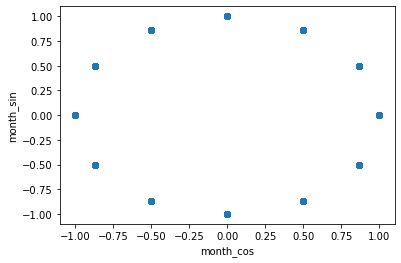

In [467]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [282]:
# YOUR CODE HERE
time_pipeline = make_pipeline(TimeFeaturesExtractor(), CyclicalEncoder())

In [294]:
#I did not manage to add a step to basic_pipeline so i'll arrange it manually

basic_pipeline = make_pipeline(basic_preprocessing, time_pipeline, l1_reg)

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [295]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [309]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [310]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [311]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6464, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [493]:
features_extractor = Pipeline(
        steps=[
        #Extract TimeFeatures
        ('time_features_extractor', TimeFeaturesExtractor())])

In [496]:
cycles_extractor = Pipeline(
        steps=[
#Encode cyclical features
        ('cyclical_encoder', CyclicalEncoder())])

In [484]:
preproc = ColumnTransformer(
    
    transformers=[
        
        # Dropping columns that will not be used by the model
        ('drop_date_and_text', 'drop', ['description', 'original_title', 'title']),
        
        # Scaling continuous features with outliers
        ('robust_scaler', RobustScaler(), ['duration_min','budget',
             'number_of_awards_won',
             'number_of_nominations',
             'has_collection',
             'number_of_top_productions']),
        
        # One-hot encoding the categorical and boolean features 
        ('key_encoding', OneHotEncoder(handle_unknown = "ignore"), ['original_language',
             'status',
             'has_collection',
             'available_in_english']),
        
                ('custom_encoding', CustomGenreAndCountryEncoder(), ['all_genres', 'top_countries'])
    ],         sparse_threshold=0
)

In [499]:
time_df = cycles_extractor.fit_transform(features_extractor.fit_transform(X[['release_date']]))
time_df


,year,month_cos,month_sin
0,2015,8.660254e-01,5.000000e-01
1,2004,-8.660254e-01,-5.000000e-01
2,2014,-8.660254e-01,5.000000e-01
3,2012,1.000000e+00,6.123234e-17
4,2012,-8.660254e-01,-5.000000e-01
...,...,...,...
6459,2001,-8.660254e-01,-5.000000e-01
6460,2004,-8.660254e-01,-5.000000e-01
6461,1982,-2.449294e-16,1.000000e+00
6462,2015,8.660254e-01,5.000000e-01


In [500]:
preproc_df = pd.DataFrame(preproc.fit_transform(X))
preproc_df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.500000,0.093863,-0.333333,-0.250000,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.333333,0.907347,-0.166667,-0.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.000000,-0.240916,15.833333,11.666667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.708333,-0.306621,3.500000,1.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.541667,0.093863,-0.333333,0.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,0.541667,0.969922,-0.333333,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6460,-0.416667,0.250303,-0.333333,-0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6461,1.000000,0.156439,0.166667,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6462,-0.208333,-0.281590,3.833333,3.166667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [502]:
final_df = preproc_df.join(time_df)
final_df

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,year,month_cos,month_sin
0,-0.500000,0.093863,-0.333333,-0.250000,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,8.660254e-01,5.000000e-01
1,0.333333,0.907347,-0.166667,-0.250000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2004,-8.660254e-01,-5.000000e-01
2,0.000000,-0.240916,15.833333,11.666667,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2014,-8.660254e-01,5.000000e-01
3,0.708333,-0.306621,3.500000,1.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012,1.000000e+00,6.123234e-17
4,-0.541667,0.093863,-0.333333,0.083333,0.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2012,-8.660254e-01,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,0.541667,0.969922,-0.333333,-0.250000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2001,-8.660254e-01,-5.000000e-01
6460,-0.416667,0.250303,-0.333333,-0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2004,-8.660254e-01,-5.000000e-01
6461,1.000000,0.156439,0.166667,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1982,-2.449294e-16,1.000000e+00
6462,-0.208333,-0.281590,3.833333,3.166667,0.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2015,8.660254e-01,5.000000e-01


📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [504]:
final_scores = cross_validate(l1_reg, final_df, y, scoring=scoring)['test_score']
-final_scores

array([0.30290531, 0.32191008, 0.31661152, 0.30284663, 0.33006447])

### 🧪 Save your result

Run the following cell to save your results.

In [506]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

PicklingError: Can't pickle <class '__main__.CyclicalEncoder'>: it's not the same object as __main__.CyclicalEncoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [46]:
# YOUR CODE HERE

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [47]:
# YOUR CODE HERE

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [53]:
# YOUR CODE HERE

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [54]:
# YOUR CODE HERE

In [55]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [507]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

NameError: name 'search' is not defined

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**